# Set up the connection to MongoDB

In [172]:
import nltk
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from src.config import *
from mongohandler import *

from bson.son import SON
from pymongo import MongoClient
from IPython.display import display, HTML

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics.pairwise import cosine_similarity as cosine_distances
from sklearn.metrics.pairwise import euclidean_distances as euclidean_distances


# IMPORTANT : Remember to start mongodb server
# run $ sudo systemctl start mongod
# Also, start the api.py Flask server
#     $ python3 api.py

In [2]:
client = MongoClient(DBURL)
db = client.messenger
print(f"Connected to MongoClient at: {DBURL}")
nltk.download('vader_lexicon')

Connected to MongoClient at: mongodb://localhost:27017


[nltk_data] Downloading package vader_lexicon to /home/rh/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

# Trying out our basic functions

To interact with the Messenger API we will use the python built-in `requests` module.

These aditionally, we will leverage on MongoDB as a database to store all relevant data for the `users` `chats` and `messages`. To do this, a `mongohandler` module with functions has also been developed and imported.

### To begin, lets use some scripts from the TV Show `Rick and Morty` to seed out API.

In [156]:
# Found this dataset on Kaggle, data can be updated by scrapping this wiki:
#  -  https://rickandmorty.fandom.com/wiki/Category:Transcripts

original_df = pd.read_csv('INPUT/RickAndMortyScripts.csv')
df = original_df
df.head(3)

,index,season no.,episode no.,episode name,name,line
0,0,1,1,Pilot,Rick,Morty! You gotta come on. Jus'... you gotta co...
1,1,1,1,Pilot,Morty,"What, Rick? What’s going on?"
2,2,1,1,Pilot,Rick,"I got a surprise for you, Morty."


### 1 - Create Users:
Endpoint: `/user/create/<username>`

In [4]:
usernames = [e for e in df.name.value_counts().index]
print(usernames[:8])

['Rick', 'Morty', 'Beth', 'Jerry', 'Summer', 'Pickle Rick', 'Supernova', 'Cop Morty']


In [5]:
def import_usernames(usernames):
    for user in usernames:
        route = f'/user/create/{user}'
        res = requests.get(flask_api+route)
    #returns only the last response
    return res

last_response = import_usernames(usernames)
print(f'We have tried to create {len(usernames)} users.')
print("Last recorded event : ")    
display(HTML(last_response.text)) # Last user created    

We have tried to create 48 users.
Last recorded event : 


### 2 - Create Public Chats
To do this, we will group the df by episode name, and use that variable as the `chat_title` to send to the API. Also, this group by allows us to see a list of the characters present on each episode.

Use this as an index to later create the group with the right members


In [6]:
chats_outline = df.groupby(['episode name', 'name']).agg({'line':'count'})
display(chats_outline.head(6))

line
episode name     name             
A Rickle in Time All Mortys     15
                 All Ricks      32
                 All Summers    13
                 Beth           30
                 Jerry          25
                 Morty          24

Also, create a list of all the episodes we are going to upload

In [7]:
all_chat_titles = df['episode name'].drop_duplicates().values
all_chat_titles

array(['Pilot', 'Lawnmower Dog', 'Rick Potion 9', 'A Rickle in Time',
       'The Wedding Squanchers', 'Get Schwifty',
       'Interdimensional Cable 2  Tempting Fate',
       'The Rickshank Rickdemption', 'Pickle Rick',
       'Vindicators 3  The Return of Worldender',
       'Tales From the Citadel'], dtype=object)

#### Sending a request to the API, for every available `chat_tile & usernames` group

In [8]:
def create_chat(chat_title, participants):
    route = f"/chat/create?title={chat_title}&users={participants}"
    res = requests.get(flask_api+route)
    return res

In [9]:
for chat_title in all_chat_titles:
    participants = list(chats_outline.loc[chat_title].index) # These are the chat_titles and usernames
    res = create_chat(chat_title, participants)

    
print("Last recorded event's http response: ")    
display(HTML(res.text))

Last recorded event's http response: 


### 3 - Add New Users to an existing chat
To do this, I have create a new dummy user `rihp`, and added it to the `get_schwifty` chat.

In [10]:
def add_user_to_chat(username, chat_title):
    route = f"/chat/{chat_title}/adduser?&username={username}"
    res = requests.get(flask_api+route)
    return res

In [11]:
username=['rihp']
chat_title = "get_schwifty"

res = import_usernames(username)
display(HTML(res.text))
print('------------------------------------------------------')
res = add_user_to_chat(*username, chat_title)
display(HTML(res.text))

------------------------------------------------------


username='rihp'
chat_title = "get_schwifty"

import_usernames(['rihp'])
res = requests.get(flask_api+f'/user/create/{username}')
display(HTML(res.text))
print('------------------------------------------------------')
route = f"/chat/{chat_title}/adduser?&username={username}"
res = requests.get(flask_api+route)
display(HTML(res.text))

### 4 - Add Messages to a public chat
Using our dataset, we will use the following columns to populate our collection of `messages`

#### To send a message, the user must be part of the chat
This function is buggy and prints a lot of verbose.
Please fix 

`check_user_in_chat('rihp', 'pickle_rick')`

In [12]:
m_outline = df[['episode name', 'name', 'line']]
m_outline.head(3)

,episode name,name,line
0,Pilot,Rick,Morty! You gotta come on. Jus'... you gotta co...
1,Pilot,Morty,"What, Rick? What’s going on?"
2,Pilot,Rick,"I got a surprise for you, Morty."


m_outline[m_outline['episode name'] == 'Pickle Rick'].tail(3)

### The execution of these cells is not very efficient
they send all the messages to the database

In [13]:
def send_message(username, chat_title, text):
    route = f"/chat/{chat_title}/addmessage?username={username}&text={text}"
    res = requests.get(flask_api+route)
    return res

In [14]:
for i in m_outline.index:
    message = m_outline.iloc[i]                         # Locate the message
    chat_title = message['episode name']                # Define the episode name
    username = message['name']                          # Define the username  
    text = message['line']                              # Define the message text
    res  = send_message(username, chat_title, text)# <----SEND MESSAGE TO API------
print("Last recorded event (The http response): ")    
display(HTML(res.text))

Last recorded event (The http response): 


### 5 - Query all the messages sent to an specific chat
- (GET) `/chat/<chat_id>/list`

Aggregate the messages in the chat, using this pipeline query on our Mongo Database

In [15]:
cur = db.chat.aggregate([{'$lookup': {
                            'from': 'messages',             # Use the messages collection
                            'localField': 'messages',   
                            'foreignField': '_id',     
                            'as': 'messages'}
                        }, 
                         {'$project': {
                            '_id': 1, 
                            'title': 1, 
                            'participants': 1, 
                            'messages': {
                                'text': 1, 
                                'username': 1}
                        }}])
CHATSquery = list(cur)

### Access the specific chat and display some of the messages
This is not the specific chat, its only the first one in the list. fix this

In [16]:
all_chat_titles = list(enumerate([doc['title'] for doc in CHATSquery]))
all_chat_titles

[(0, 'pilot'),
 (1, 'lawnmower_dog'),
 (2, 'rick_potion_9'),
 (3, 'a_rickle_in_time'),
 (4, 'the_wedding_squanchers'),
 (5, 'get_schwifty'),
 (6, 'interdimensional_cable_2__tempting_fate'),
 (7, 'the_rickshank_rickdemption'),
 (8, 'pickle_rick'),
 (9, 'vindicators_3__the_return_of_worldender'),
 (10, 'tales_from_the_citadel')]

### Access the first 5 lines of the `Pickle Rick` episode, index `8`

In [17]:
for i in range(5):
    print(CHATSquery[8]['messages'][i]['text']) 

Morty.
Rick?
Morty!
Rick?
Hey, Mooorty!


### 6 - Perform a Sentiment analysis on an specific chat message history
- (GET) `/chat/<chat_id>/sentiment`

In this case, we will start analyzing Rick and Morty's (Season 1, Episode 5), `Get Schwifty`.

In [18]:
# This function takes in a pymongo CHATSquery cursor
# which has already been turned into a list
# and looks for an specific chat title.

def get_chat_doc(chat_title, query):
    for i in range(len(query)):
        if query[i]['title'] == chat_title:
            yield query[i]

#### Set the chat_title variable

In [24]:
episode = 'Get Schwifty'
chat_title = no_spaces(episode).lower()
chat_messages = list(get_chat_doc(chat_title, CHATSquery))[0]['messages']

In [25]:
check_original_data = False
if check_original_data:
    if len(chat_messages) != df['episode name'].value_counts()[episode]: 
        raise Exception('something is wrong here, the database has more messages than it should have')

#### Begin the sentiment analysis of that chat room

In [26]:
sia = SentimentIntensityAnalyzer()

In [27]:
def analyze_chat_sentiment(chat_messages):
    for i in range(len(chat_messages)):
        text = chat_messages[i]['text']
        yield sia.polarity_scores(text) # Analyze this

In [28]:
print(f"Sentiment analysis for the chat: \n {chat_title}")
sentiment = pd.DataFrame(list(analyze_chat_sentiment(chat_messages)))
display(sentiment.describe())

Sentiment analysis for the chat: 
 get_schwifty


,neg,neu,pos,compound
count,442.000000,442.000000,442.000000,442.000000
mean,0.104633,0.780190,0.115186,0.046848
std,0.200433,0.239615,0.186973,0.432650
min,0.000000,0.000000,0.000000,-0.891000
25%,0.000000,0.647000,0.000000,-0.102700
50%,0.000000,0.809000,0.000000,0.000000
75%,0.133000,1.000000,0.191000,0.361200
max,1.000000,1.000000,1.000000,0.978500


#### Get the mean compound for all the chats

In [29]:
def get_chats_sia_scores(all_chat_titles, query):
    overall_scores = {}
    for episode_num, chat_title in all_chat_titles:
        chat_messages = list(get_chat_doc(chat_title, query))[0]['messages']
        sentiment = pd.DataFrame(list(analyze_chat_sentiment(chat_messages)))
        overall_scores.update({chat_title:sentiment.describe().loc['mean']['compound']})
    return pd.DataFrame.from_dict(overall_scores, orient='index', columns=['mean_compound_score'])

<BarContainer object of 11 artists>

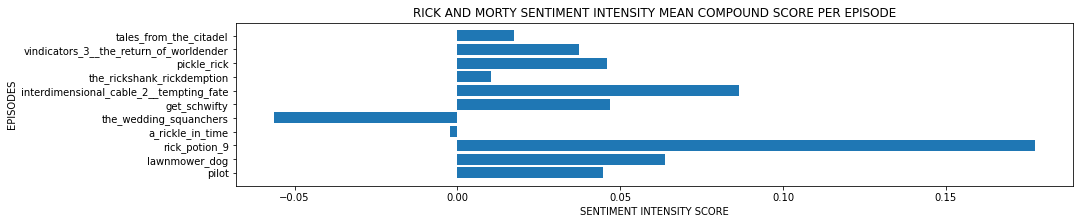

In [116]:
all_chats_sia_scores = get_chats_sia_scores(all_chat_titles, CHATSquery)
plt.figure(figsize=(15,3))
plt.ylabel('EPISODES')
plt.xlabel('SENTIMENT INTENSITY SCORE')
plt.title('RICK AND MORTY SENTIMENT INTENSITY MEAN COMPOUND SCORE PER EPISODE')
plt.barh(all_chats_sia_scores.index,all_chats_sia_scores.mean_compound_score )

### 7 - Query all the messages from an specific user, and perform SIA

In [48]:
cur = db.user.aggregate([{'$lookup': {
                                'from': 'messages',             
                                'localField': 'messages_sent', 
                                'foreignField': '_id', 
                                'as': 'all_messages'}
                        },
                         {'$project': {
                                'username': 1,
                                'all_messages': {
                                    'text': 1}}}])
query = list(cur)

####  Use a query, find a username and create an iterator that includes all the messages from that username

In [49]:
def iter_messages_from_user(query, username):
    for user_doc in query:                               # Exploring the query
        if user_doc['_id'] == get_user_id(username):     # Finding an specific user id   
            for message in user_doc['all_messages']:     # Looping through the messages
                yield message['text']                    # Analyze these raw strings

In [50]:
username = 'Morty'

In [51]:
all_user_messages = list(iter_messages_from_user(query, username))   # As an array of strings
all_user_messages[:2]

['What, Rick? What’s going on?',
 "It's the middle of the night. What are you talking about?"]

#### Take an array of strings and create an iterator of SIA scores

In [52]:
def iter_sia_scores(array_of_strings):
    for i in range(len(array_of_strings)):
        text = array_of_strings[i]            # Define the raw string to be analyzed
        yield sia.polarity_scores(text)       # Yield the results of the Polarity Score for each message

In [53]:
user_scores = list(iter_sia_scores(all_user_messages))
user_scores[:2]

[{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}]

#### Pass a list of sia scores, and return a pandas dataframe

In [54]:
print(f"Describing Sentiment Intensity Analysis for this user:\n {username}") 
to_df = lambda x : pd.DataFrame(x)
to_df(user_scores).describe()

Describing Sentiment Intensity Analysis for this user:
 Morty


,neg,neu,pos,compound
count,694.000000,694.000000,694.000000,694.000000
mean,0.089723,0.793602,0.116657,0.029093
std,0.176528,0.248271,0.202114,0.379227
min,0.000000,0.000000,0.000000,-0.910800
25%,0.000000,0.645250,0.000000,0.000000
50%,0.000000,0.861000,0.000000,0.000000
75%,0.100750,1.000000,0.191750,0.273200
max,0.851000,1.000000,1.000000,0.955600


In [83]:
def compare_user_sia(query):
    for doc in query:
        username = doc['username']

        # Check the username and how many messsages have been sent
        #print(username, len(doc['all_messages']))
    #    if username == 'rick':    

        if len(doc['all_messages']) == 0: continue

        # Create an iterator of messages from the user described above,
        all_user_messages = list(iter_messages_from_user(query, username))
        # And turn them into Sentiment Intensity Analysis scores.
        user_scores = list(iter_sia_scores(all_user_messages))
        compound_mean = to_df(user_scores)['compound'].mean()
        #print(f"Describing Sentiment Intensity Analysis for this user:\n {username}") 

        #display(to_df(user_scores).describe())
        #print(username, to_df(user_scores)['compound'].mean())
        #container.append((username, to_df(user_scores)['compound'].mean()))
        yield username, to_df(user_scores)['compound'].mean()
sia_vectors = list(compare_user_sia(query))


,0,1
0,rick,0.042016
1,morty,0.029093
2,beth,0.052355
3,jerry,0.116464
4,summer,0.060132
5,pickle_rick,0.027861
6,supernova,0.060534
7,cop_morty,-0.020550
8,all_ricks,-0.052341
9,mr._goldenfold,0.089064


<BarContainer object of 48 artists>

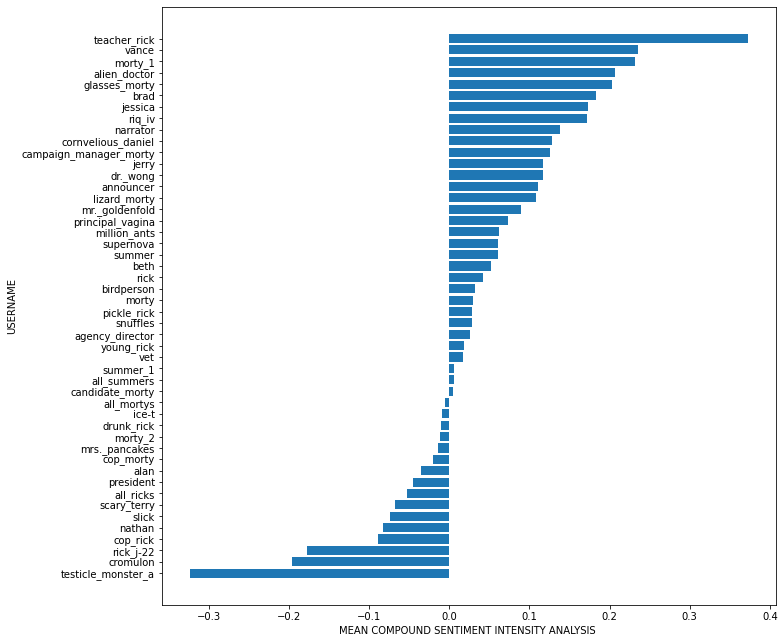

In [112]:
df = to_df(sia_vectors)
df = df.sort_values(by=1)
plt.figure (figsize=(11,11))
plt.xlabel('MEAN COMPOUND SENTIMENT INTENSITY ANALYSIS ')
plt.ylabel('USERNAME')
plt.barh(df[0], df[1])

### 8 - Recommender system takes in an `user_id` and return top-3 similar `users`
- (GET) `/user/<user_id>/recommend`

### Prepare a dict: { 'rick':'all their messages joined in a single string'}


In [141]:
rick = 'rick'
morty = 'morty'
beth = 'beth'
jerry = 'jerry'

In [157]:
df = original_df
usernames = [e for e in df.name.value_counts().index]

In [160]:
print(usernames [:10])

['Rick', 'Morty', 'Beth', 'Jerry', 'Summer', 'Pickle Rick', 'Supernova', 'Cop Morty', 'All Ricks', 'Mr. Goldenfold']


### All messages as a single string
This produces an error with the `'` key, as it's showing as a backslash that could probably alter the meaning of the strings 

In [142]:


# 
raw_corpus = lambda query, username : " ".join(list(iter_messages_from_user(query, username)))   

docs = {
    rick : raw_corpus(query, rick),
    morty: raw_corpus(query, morty),
    beth:  raw_corpus(query, beth),
    jerry: raw_corpus(query, jerry),
}

In [164]:

docs = {}
for username in usernames:
    username = no_spaces(username).lower()
    docs.update({f"{username}":f"{raw_corpus(query, username)}"})

In [143]:
from sklearn.feature_extraction.text import CountVectorizer


In [195]:
count_vectorizer = CountVectorizer()
sparse_matrix = count_vectorizer.fit_transform(docs.values())
print(list(count_vectorizer.vocabulary_.keys())[:20])
m = sparse_matrix.todense()
print(m.shape)
print(m[0])

['morty', 'you', 'gotta', 'come', 'on', 'jus', 'with', 'me', 'got', 'surprise', 'for', 'hurry', 'up', 'we', 'go', 'get', 'outta', 'here', 'what', 'do']
(48, 3392)
[[0 2 8 ... 0 0 0]]


In [191]:
doc_term_matrix = sparse_matrix.todense()
df = pd.DataFrame(doc_term_matrix, 
                  columns=count_vectorizer.get_feature_names(), 
                  index=docs.keys())
display(df.tail())

,000,10,100,11,12,137,16,1998,20,200,...,yourself,yourselves,youtube,yup,yyyyyyyyyyou,zero,zipped,zit,zone,zorpathion
teacher_rick,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
announcer,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,4,0
narrator,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
mrs._pancakes,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
summer_1,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0


#### Query specific words to explore the data for more human similarities

In [204]:
my_words = ["youtube", "dimension", "me", "my", "mine", "you", "your", "their", "them", "friend", "enemy", ]
display(df[my_words].sort_values(by=my_words, ascending=False).head())

,youtube,dimension,me,my,mine,you,your,their,them,friend,enemy
pickle_rick,2,0,16,18,0,54,12,4,0,0,0
rick,0,8,128,104,8,578,146,10,46,2,2
testicle_monster_a,0,2,6,6,0,68,14,0,0,0,0
rick_j-22,0,2,4,0,0,6,4,0,0,0,0
morty,0,0,40,66,2,296,16,6,16,0,0


In [173]:
#cosine_distances
similarity_matrix = euclidean_distances(df,df)
print(similarity_matrix)

[[   0.          883.03114328 1061.40849818 ... 1278.65554392
  1291.36207161 1291.47202835]
 [ 883.03114328    0.          377.36454523 ...  564.85750415
   578.33554274  579.76202014]
 [1061.40849818  377.36454523    0.         ...  267.32003292
   275.9347749   276.49231454]
 ...
 [1278.65554392  564.85750415  267.32003292 ...    0.
    48.90807704   46.        ]
 [1291.36207161  578.33554274  275.9347749  ...   48.90807704
     0.           21.44761059]
 [1291.47202835  579.76202014  276.49231454 ...   46.
    21.44761059    0.        ]]


In [209]:
sim_df = pd.DataFrame(similarity_matrix, columns=docs.keys(), index=docs.keys())
display(sim_df)

,rick,morty,beth,jerry,summer,pickle_rick,supernova,cop_morty,all_ricks,mr._goldenfold,...,glasses_morty,birdperson,vet,rick_j-22,morty_1,teacher_rick,announcer,narrator,mrs._pancakes,summer_1
glasses_morty,1292.670105,580.623802,277.618443,294.801628,161.058995,165.142363,80.622577,64.062470,152.381101,58.549125,...,0.000000,36.276714,23.748684,24.331050,20.396078,26.832816,31.048349,44.226689,22.538855,19.595918
young_rick,1292.249202,580.885531,278.768721,294.204011,162.024689,163.780341,81.117199,63.874878,152.721970,56.391489,...,22.627417,35.383612,23.916521,26.229754,23.151674,27.856777,31.048349,42.000000,26.608269,23.832751
lizard_morty,1292.133120,581.453352,277.495946,294.441845,161.319559,164.839316,80.249611,64.961527,151.631131,59.126982,...,21.260292,37.309516,27.568098,26.305893,24.738634,29.866369,32.372828,46.389654,26.981475,23.409400
summer_1,1291.472028,579.762020,276.492315,294.625186,159.637088,164.535710,79.924965,63.498031,151.538774,59.025418,...,19.595918,35.042831,24.738634,25.612497,18.761663,28.705400,33.045423,46.000000,21.447611,0.000000
mrs._pancakes,1291.362072,578.335543,275.934775,294.102023,160.049992,163.768129,80.498447,64.714759,149.479096,60.266077,...,22.538855,36.221541,24.819347,27.784888,23.065125,28.495614,36.551334,48.908077,0.000000,21.447611
all_summers,1290.100771,577.941173,274.772633,291.712187,158.088583,163.327891,78.943017,63.906181,150.066652,58.787754,...,21.260292,35.552778,26.683328,27.202941,21.633308,30.397368,32.863353,45.956501,25.139610,18.654758
morty_1,1289.776725,577.896184,275.041815,292.554268,157.136883,162.037033,79.018985,60.530984,149.519230,55.749439,...,20.396078,34.117444,24.738634,25.139610,0.000000,29.393877,31.559468,43.497126,23.065125,18.761663
announcer,1289.195098,578.950775,276.021738,292.533759,159.849930,161.950610,80.249611,64.156060,151.155549,58.446557,...,31.048349,38.262253,34.525353,33.045423,31.559468,35.944402,0.000000,45.869380,36.551334,33.045423
vet,1289.145453,576.922872,274.306398,291.053260,158.467662,160.536600,79.498428,63.150614,150.386170,57.827329,...,23.748684,36.221541,0.000000,27.784888,24.738634,29.597297,34.525353,43.908997,24.819347,24.738634
teacher_rick,1286.945220,576.621193,274.284524,291.073874,158.455041,160.549058,78.051265,61.644140,150.079979,58.889727,...,26.832816,33.166248,29.597297,28.982753,29.393877,0.000000,35.944402,45.650849,28.495614,28.705400


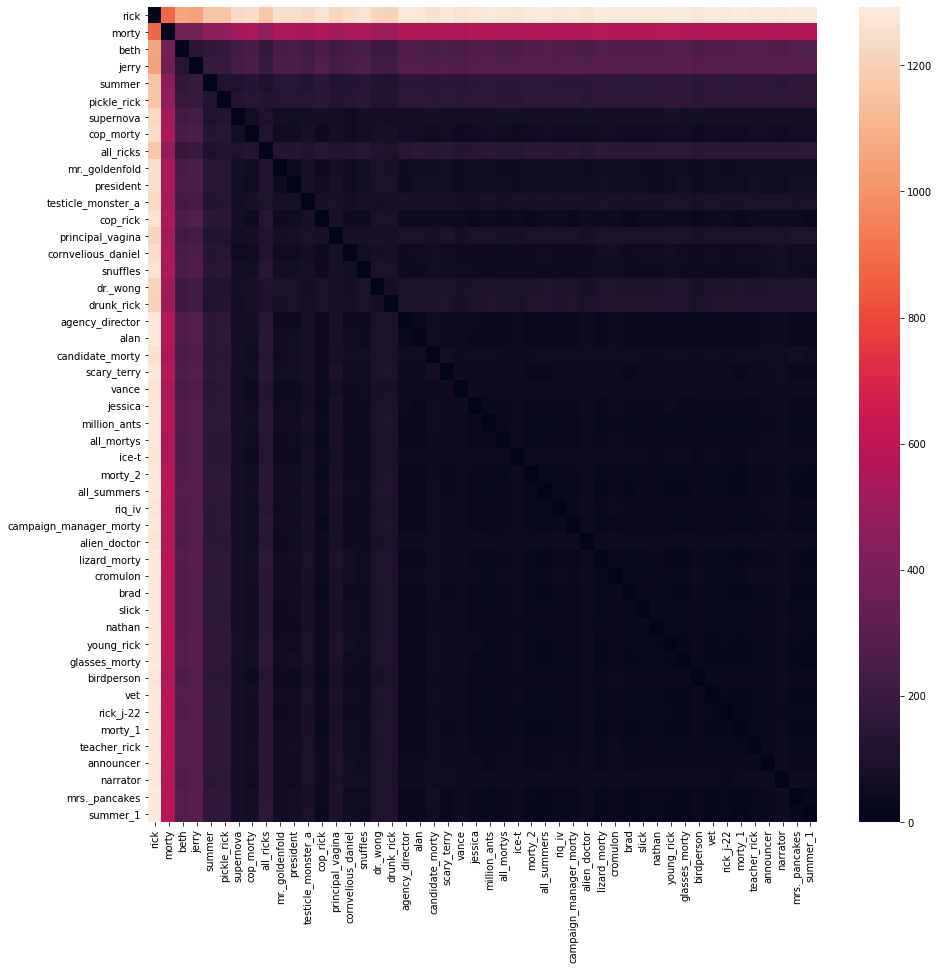

In [207]:
plt.figure(figsize=(15,15))
sns.heatmap(sim_df,annot=False)

#### The 3 users that are most similar to the user 'RICK'

In [220]:
similar_to_rick = sim_df['rick']
display(similar_to_rick.sort_values(ascending=True).iloc[1:4])

morty     883.031143
jerry    1046.158688
beth     1061.408498
Name: rick, dtype: float64

### 9 - Move local database to MongoAtlas cloud

### 10 - Prepare Docker Image

### 11  - Deploy Docker Image in Heroku

In [ ]:
# Some basic checking:
Is there a chat 